In [25]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper')
sns.set_style('white')

# Lecture 24 - Deep Neural Networks

## Objectives

+ Understand the basics of `PyTorch`.
+ Set up and train regression DNNs with `PyTorch`

## References 

+ Reading Activity 24
+ Chapters 6, 7, and 8 of https://www.deeplearningbook.org/
+ [Deep Learning with PyTorch: A 60 minute blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) and in particular:
    - [What is PyTorch?](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py)
    - [Autograd: Automatic differentation](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py)
    - [Neural networks](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py)

## What is PyTorch and why are we using it?

+ PyTorch is an alternative to Numpy that can harness the power of [GPUs](https://en.wikipedia.org/wiki/Graphics_processing_unit).
+ PyTorch provides some core functionality for Neural Networks:
    - Some basic elements for building them up like linear layers, activation functions, etc.
    - Automatic differentation for getting the derivative of loss functions with respect to parameters.
    - Some stochastic optimization algorithms for minimizing loss functions
    - ...

I am not going to provide here a complete tutorial of PyTorch.
You are advised to go over the first three topics of the [Deep Learning with PyTorch: A 60 minute blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) prior to beginning this hands-on activity.
Otherwise, it is unlikely that you understand the code that follows.

PyTorch was developed by the Facebook AI Research Group.
There is another powerful alternative developed by Google Brain: [TensorFlow](https://www.tensorflow.org/).
I find PyTorch easier to use than TensorFlow and that's why we only use this in this class.

## Making neural networks in PyTorch

PyTorch is fairly flexible in allowing you to make any type neural network you like.
You have absolute freedom on how your model looks like.
However, it does provide a super easy way to make dense neural networks with a fixed activation function.
That's what we are going to start with.
First, import torch:

In [26]:
import torch

The submodule `torch.nn` is where the neural network building blocks reside:

In [27]:
import torch.nn as nn

First, let me show you how you can make a single linear layer:
$$
y = Wx + b.
$$
The weights are selected randomly if not specified.
Here you go:

In [28]:
layer = nn.Linear(1, 20)

This is now a function that takes one dimensional inputs and spits out 20 dimensional outputs.
Here is how it works:

In [29]:
x = torch.rand(10, 1) # 10 randomly sampled one dimensinal inputs
print(x)

tensor([[0.3341],
        [0.8044],
        [0.2742],
        [0.8665],
        [0.7738],
        [0.3158],
        [0.6246],
        [0.6490],
        [0.9892],
        [0.6280]])


In [30]:
y = layer(x)
print(y)

tensor([[ 5.0784e-01, -3.5283e-01,  2.5785e-01,  7.5132e-01,  3.9920e-01,
         -8.6749e-02,  4.7012e-01,  9.4173e-01,  7.0942e-01, -1.8253e-01,
         -6.9069e-02, -4.3936e-01, -5.4792e-01, -5.5827e-01,  4.6429e-01,
          8.9633e-01, -1.0537e-01, -6.1590e-01, -3.5250e-02,  3.2763e-01],
        [ 7.1228e-01, -6.7590e-01, -1.2817e-01,  9.4162e-01,  3.3157e-01,
         -4.9168e-01,  7.4657e-01,  8.6173e-01,  3.1289e-01, -4.4753e-01,
         -1.2546e-01, -3.3079e-01, -7.6782e-01, -8.1059e-01,  2.6038e-01,
          1.1581e+00, -3.3458e-01, -3.5073e-01, -3.2443e-01,  7.1753e-01],
        [ 4.8178e-01, -3.1164e-01,  3.0706e-01,  7.2706e-01,  4.0783e-01,
         -3.5125e-02,  4.3487e-01,  9.5192e-01,  7.5997e-01, -1.4874e-01,
         -6.1879e-02, -4.5320e-01, -5.1988e-01, -5.2610e-01,  4.9029e-01,
          8.6297e-01, -7.6151e-02, -6.4971e-01,  1.6172e-03,  2.7792e-01],
        [ 7.3925e-01, -7.1853e-01, -1.7911e-01,  9.6673e-01,  3.2264e-01,
         -5.4511e-01,  7.8305e-01, 

In [7]:
print(y.shape)

torch.Size([10, 20])


So, this took us to 10, 20 dimensional outputs. Looks good.

But where are the weights and the bias term?
Here they are:

In [8]:
layer.weight

Parameter containing:
tensor([[-0.7244],
        [ 0.6246],
        [ 0.4859],
        [-0.4511],
        [ 0.3415],
        [ 0.1848],
        [-0.2098],
        [-0.1523],
        [-0.8029],
        [-0.0259],
        [-0.4943],
        [-0.1734],
        [-0.3771],
        [-0.2689],
        [ 0.7109],
        [ 0.6460],
        [-0.3977],
        [ 0.4483],
        [ 0.3539],
        [-0.8201]], requires_grad=True)

In [9]:
layer.bias

Parameter containing:
tensor([-0.6055,  0.4345, -0.4334,  0.1397, -0.2797,  0.4837, -0.6142,  0.4432,
         0.4403, -0.8492, -0.5207,  0.7993,  0.3730,  0.1382, -0.1678, -0.4408,
         0.5537, -0.3103, -0.2265,  0.6833], requires_grad=True)

You can directly change them if you wish.
Notice the `requires_grad=True` flag.
This is because PyTorch knows that these are parameters to be optimized.

There is a little bit of flexibility on `nn.Linear`.
For example, you can completly drop the bias if you wish.
For the complete list of possibilities, you should always [check the docs](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html).

Now, let's get to the activation functions.
There are a lot already in `torch.nn`.
Here is the sigmoid:

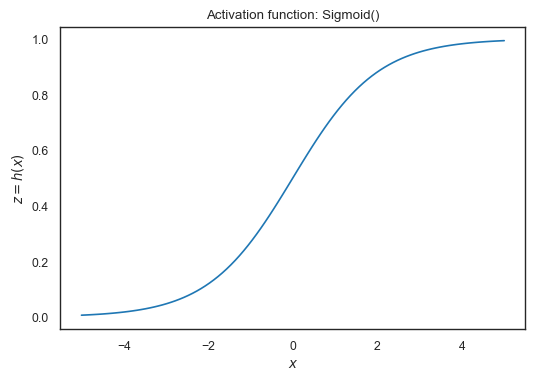

In [10]:
h = nn.Sigmoid()

fig, ax = plt.subplots(dpi=100)
x = torch.linspace(-5, 5, 100)[:, None]
ax.plot(x, h(x))
ax.set_xlabel('$x$')
ax.set_ylabel('$z=h(x)$')
ax.set_title('Activation function: ' + str(h));

Now, you could also implement the activation fuction by hand.
The only restriction is that you should be using `PyTorch` functions instead of `numpy` functions.
Here is how we would do it for the sigmoid:

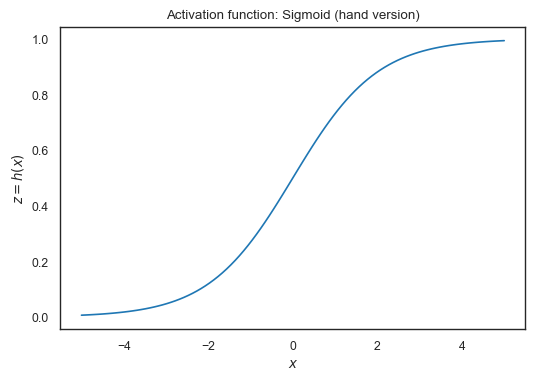

In [11]:
# Here is how you could do this by hand:
h_by_hand = lambda x: torch.exp(x) / (1.0 + torch.exp(x))

fig, ax = plt.subplots(dpi=100)
ax.plot(x, h_by_hand(x))
ax.set_xlabel('$x$')
ax.set_ylabel('$z=h(x)$')
ax.set_title('Activation function: Sigmoid (hand version)');

Here are now some of the most commonly used activation functions in `torch.nn`:

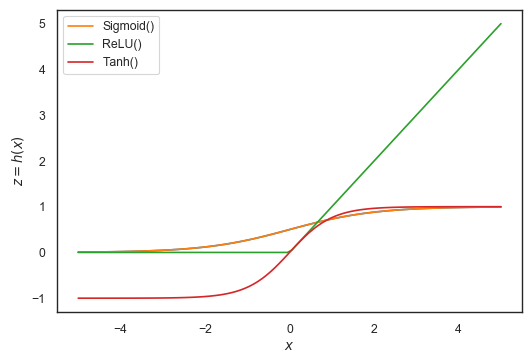

In [12]:
fig, ax = plt.subplots(dpi=100)
ax.plot(x, h_by_hand(x))

for Func in [nn.Sigmoid, nn.ReLU, nn.Tanh]:
    h = Func()
    ax.plot(x, h(x), label=str(h))
    
ax.set_xlabel('$x$')
ax.set_ylabel('$z=h(x)$')
plt.legend(loc='best');

Now that we have a linear layer and an activation function here is how we can combine them to make a function that takes us from the input to the internal neurons:

In [13]:
h = nn.Sigmoid()
z_func = lambda x: h(layer(x))

This is pretty much it. And that's now a function:

In [14]:
z_func(x)

tensor([[0.9533, 0.0637, 0.0540,  ..., 0.0723, 0.1196, 0.9917],
        [0.9500, 0.0675, 0.0566,  ..., 0.0754, 0.1234, 0.9910],
        [0.9464, 0.0716, 0.0593,  ..., 0.0786, 0.1273, 0.9902],
        ...,
        [0.0166, 0.9687, 0.8696,  ..., 0.8630, 0.8133, 0.0373],
        [0.0155, 0.9705, 0.8751,  ..., 0.8683, 0.8187, 0.0344],
        [0.0144, 0.9723, 0.8804,  ..., 0.8734, 0.8239, 0.0318]],
       grad_fn=<SigmoidBackward>)

Now, for regression, we would like to bring this back to a scalar output.
To do this, we need to add one more linear layer taking the 20 internal neurons, back to one dimension.


In [15]:
final_layer = nn.Linear(20, 1)
f = lambda x: final_layer(z_func(x))
print(f(x).shape)

torch.Size([100, 1])


Instead of doing this manually, we can can use the class `nn.Sequential` of PyTorch:

In [17]:
f = nn.Sequential(layer, nn.Sigmoid(), final_layer)

This is the recommended way, because `nn.Sequential` adds some additional functionality which I will show you in a while.
You can evaluate this as a function, and you can also plot it.
But to plot it, you have to turn the output into a proper numpy array.
This is because matplotlib doesn't like PyTorch tensors that depend on parameters.
Here is what you need to do:

In [18]:
y = f(x).detach().numpy() # detach freezes the parameters to whatever they are
                          # numpy returns a proper numpy array
print(type(y))
print(y.shape)

<class 'numpy.ndarray'>
(100, 1)


And here is how it looks like (remember the weights are random):

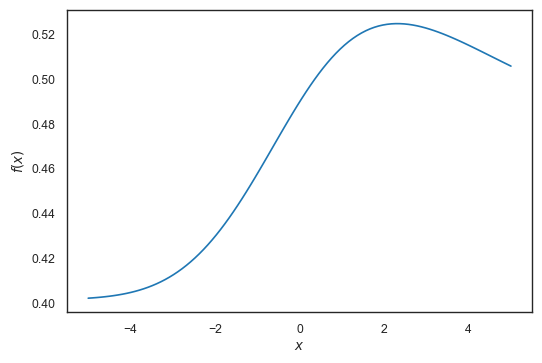

In [19]:
fig, ax = plt.subplots(dpi=100)
ax.plot(x, f(x).detach().numpy())
ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$');

The class `nn.Sequential` is very convenient, because it allows us to build very deep networks really quickly.
Here is a 5-layer network that starts from one input, takes us through 3 layers with 20 neurons each, and ends on a single output:

In [87]:
f = nn.Sequential(nn.Linear(1, 20),
                  nn.ReLU(),
                  nn.Linear(20, 20),
                  nn.ReLU(),
                  nn.Linear(20, 20),
                  nn.ReLU(),
                  nn.Linear(20, 20),
                  nn.ReLU(),
                  nn.Linear(20, 1))

Where are the parameters in an object created in this way?
Here they are:

In [88]:
for theta in f.named_parameters():
    print(theta)

('0.weight', Parameter containing:
tensor([[ 0.3035],
        [ 0.5930],
        [ 0.9063],
        [-0.7944],
        [-0.0610],
        [ 0.2787],
        [ 0.1751],
        [-0.0431],
        [ 0.4629],
        [-0.6280],
        [-0.3923],
        [ 0.7252],
        [ 0.0772],
        [-0.0883],
        [ 0.1975],
        [-0.4261],
        [ 0.8586],
        [ 0.6889],
        [-0.5676],
        [ 0.6125]], requires_grad=True))
('0.bias', Parameter containing:
tensor([ 0.2299, -0.4280, -0.7479, -0.9647, -0.1006,  0.5401, -0.5825, -0.0463,
         0.2006,  0.0379,  0.6883,  0.5412,  0.6089, -0.6211, -0.7432,  0.8517,
        -0.0613,  0.6130, -0.4536, -0.5662], requires_grad=True))
('2.weight', Parameter containing:
tensor([[ 0.1534, -0.0016,  0.0610, -0.1348,  0.0314, -0.0795,  0.0918,  0.2060,
         -0.1986,  0.0733,  0.2074, -0.2046, -0.2092, -0.0370,  0.1118, -0.0611,
         -0.1924,  0.0717,  0.0059,  0.0587],
        [-0.0519, -0.0580,  0.1242, -0.0063,  0.1547, -0.1757

And that's why we love PyTorch. Because it does all the dirty work for us.
Imagine having to keep track of all these parameters by hand.

For those of you who want to know what is going on inside `nn.Linear`, just note that it is a special case of a PyTorch neural network module, see [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html).
The latter is what you would directly inherit when writing your own class for a non-standard neural network.
We are not going to cover it in this class, but you can find plenty of examples [here](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html).

## Making a loss function

Let's now make the loss function that we want to minimize.
It needs to be a `PyTorch` function as well.
For regression problems, we can think of the loss as a function of the model predictions and the observed data.
That is the depends on the parameters comes through the predictions.
Let's write down the mean square error (MSE) loss in this form.
It is:
$$
L_{\text{MSE}}(\theta) = L_{\text{MSE}}(y_{1:n}, f(x_{1:n};\theta)) = \frac{1}{n}\sum_{i=1}^n\left[y_i-f(x_i;\theta)\right]^2,
$$
where $x_{1:n}$ are the observed inputs (features), $y_{1:n}$ are the observed outputs (targets), and $f(x_{1:n};\theta)$ contains the model predictions on the observed inputs.

You can implement the MSE loss like this:

In [89]:
mse_loss_ours = lambda y, f: torch.mean((y - f) ** 2)

Or we can use built-in PyTorch functionality:

In [90]:
mse_loss = nn.MSELoss()

Let's evaluate it for some random data:

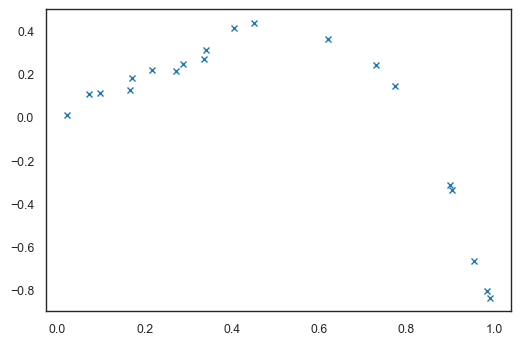

In [136]:
# The number of fake observations
n = 20
# Some fake observed features
x_fake = torch.rand(n, 1)
# Some fake observed targets
y_fake = 4 * x_fake ** 2 - 5 * x_fake ** 3 + 0.1 * torch.rand(n, 1)
fig, ax = plt.subplots(dpi=100)
ax.plot(x_fake, y_fake, 'x');

And here is how to calculate the loss (for the random parameters that our net started with):

In [137]:
# Predict with the net:
y_pred = f(x_fake)
# Evaluate the loss
our_loss = mse_loss_ours(y_fake, y_pred)
built_in_loss = mse_loss(y_fake, y_pred)
print(our_loss)
print(built_in_loss)

tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)


Now, let's just minimize the MSE loss for these fake data and see what kind of fit we are going to get.
Here is how you do this in PyTorch.
Since I don't have a lot of data, I will just use gradient descent - no randomly subsampling the data.
I will show you how you can use stochastic gradient descent in the next example.

In [138]:
# Reinitialize the net:
f = nn.Sequential(nn.Linear(1, 20),
                  nn.ReLU(),
                  nn.Linear(20, 20),
                  nn.ReLU(),
                  nn.Linear(20, 20),
                  nn.ReLU(),
                  nn.Linear(20, 20),
                  nn.ReLU(),
                  nn.Linear(20, 1))

# Initialize the optimizer - Notice that it needs to know about the 
# parameters it is optimizing
optimizer = torch.optim.SGD(f.parameters(), lr=0.01) # lr is the learning rate
# Iterate the optimizer. Let's just do 10 iterations.
for i in range(100):
    # This is essential for the optimizer to keep
    # track of the gradients correctly
    # It is using some buffers internally that need to
    # be manually zeroed on each iteration.
    # This is because it doesn't know when you are done with the
    # calculation of the loss
    optimizer.zero_grad()
    # Make predictions
    y_pred = f(x_fake)
    # Evaluate the loss - That's what you are minimizing
    loss = mse_loss(y_fake, y_pred)
    # Evaluate the derivative of the loss with respect to
    # all parameters - It knows how to do it because of
    # PyTorch magick
    loss.backward()
    # And now you are ready to make a step
    optimizer.step()
    # Print the loss every one hundend iterations:
    print('it = {0:d}: loss = {1:1.2f}'.format(i, loss.item()))

it = 0: loss = 0.17
it = 1: loss = 0.16
it = 2: loss = 0.16
it = 3: loss = 0.16
it = 4: loss = 0.16
it = 5: loss = 0.16
it = 6: loss = 0.16
it = 7: loss = 0.16
it = 8: loss = 0.16
it = 9: loss = 0.16
it = 10: loss = 0.16
it = 11: loss = 0.16
it = 12: loss = 0.16
it = 13: loss = 0.16
it = 14: loss = 0.15
it = 15: loss = 0.15
it = 16: loss = 0.15
it = 17: loss = 0.15
it = 18: loss = 0.15
it = 19: loss = 0.15
it = 20: loss = 0.15
it = 21: loss = 0.15
it = 22: loss = 0.15
it = 23: loss = 0.15
it = 24: loss = 0.15
it = 25: loss = 0.15
it = 26: loss = 0.15
it = 27: loss = 0.15
it = 28: loss = 0.15
it = 29: loss = 0.15
it = 30: loss = 0.15
it = 31: loss = 0.15
it = 32: loss = 0.15
it = 33: loss = 0.15
it = 34: loss = 0.15
it = 35: loss = 0.15
it = 36: loss = 0.15
it = 37: loss = 0.15
it = 38: loss = 0.15
it = 39: loss = 0.15
it = 40: loss = 0.15
it = 41: loss = 0.15
it = 42: loss = 0.15
it = 43: loss = 0.15
it = 44: loss = 0.15
it = 45: loss = 0.15
it = 46: loss = 0.15
it = 47: loss = 0.15
it

Let's plot the predictions of this model on the fake data:

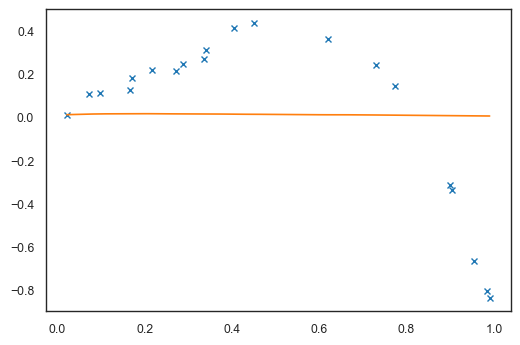

In [139]:
fig, ax = plt.subplots(dpi=100)
ax.plot(x_fake, y_fake, 'x');
xx = torch.linspace(x_fake.min(), x_fake.max(), 100)[:, None]
yy = f(xx).detach().numpy()
ax.plot(xx, yy);

It fitted a streight line.
This doesn't look very right, but it is what it is.
This is the phenomenon we described in class.
Unless you do stochastic optimization, i.e., subsampling the data, this may find a bad local minimum of the loss.

Let's redo this thing with stochastic optimization.
For stochastic optimization we need to subsample the data during each iteration.
We can either do this manually or using PyTorch functionality.
First, let's do it manually.

In [143]:
# Pick a subsampling batch size
m = 5

# Reinitialize the net:
f = nn.Sequential(nn.Linear(1, 20),
                  nn.ReLU(),
                  nn.Linear(20, 20),
                  nn.ReLU(),
                  nn.Linear(20, 20),
                  nn.ReLU(),
                  nn.Linear(20, 20),
                  nn.ReLU(),
                  nn.Linear(20, 1))

# Reinitialize the optimizer
optimizer = torch.optim.SGD(f.parameters(), lr=0.01)

# Iterate the optimizer. Let's just do 10 iterations.
for i in range(50000):
    # Zero out the gradient buffers
    optimizer.zero_grad()
    # Sample m observation indices at random
    idx = np.random.randint(0, n, m)
    # Here is the subsample of the data
    x_batch = x_fake[idx]
    y_batch = y_fake[idx]
    # Make predictions
    y_pred = f(x_batch)
    # Evaluate the loss - That's what you are minimizing
    loss = mse_loss(y_batch, y_pred)
    # Evaluate the derivative of the loss with respect to
    # all parameters - It knows how to do it because of
    # PyTorch magick
    loss.backward()
    # And now you are ready to make a step
    optimizer.step()
    # Print the loss every one hundend iterations:
    if i % 1000 == 0:
        print('it = {0:d}: loss = {1:1.2e}'.format(i, loss.item()))

it = 0: loss = 2.01e-01
it = 1000: loss = 2.03e-01
it = 2000: loss = 3.21e-02
it = 3000: loss = 3.07e-02
it = 4000: loss = 6.17e-03
it = 5000: loss = 4.43e-03
it = 6000: loss = 1.12e-03
it = 7000: loss = 1.46e-03
it = 8000: loss = 5.51e-04
it = 9000: loss = 3.87e-04
it = 10000: loss = 3.23e-04
it = 11000: loss = 9.46e-04
it = 12000: loss = 9.60e-04
it = 13000: loss = 7.89e-04
it = 14000: loss = 5.03e-04
it = 15000: loss = 5.02e-04
it = 16000: loss = 6.00e-04
it = 17000: loss = 7.69e-04
it = 18000: loss = 7.98e-04
it = 19000: loss = 7.66e-04
it = 20000: loss = 8.39e-04
it = 21000: loss = 6.71e-04
it = 22000: loss = 7.49e-04
it = 23000: loss = 4.25e-04
it = 24000: loss = 3.92e-04
it = 25000: loss = 4.11e-04
it = 26000: loss = 3.83e-04
it = 27000: loss = 4.30e-04
it = 28000: loss = 9.15e-04
it = 29000: loss = 5.98e-04
it = 30000: loss = 4.01e-04
it = 31000: loss = 9.22e-04
it = 32000: loss = 5.31e-04
it = 33000: loss = 8.77e-04
it = 34000: loss = 6.57e-04
it = 35000: loss = 2.26e-04
it = 

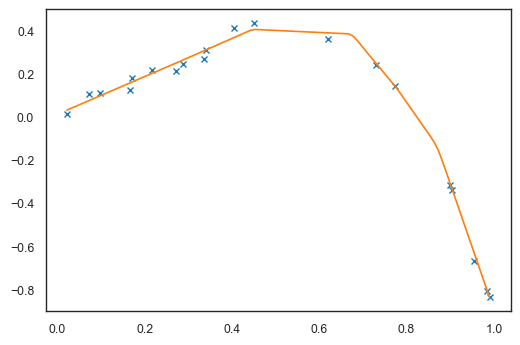

In [144]:
fig, ax = plt.subplots(dpi=100)
ax.plot(x_fake, y_fake, 'x');
xx = torch.linspace(x_fake.min(), x_fake.max(), 100)[:, None]
yy = f(xx).detach().numpy()
ax.plot(xx, yy);

This is by no means the only way to do it.
But it is one of the easiest ways.
Just pay attention to the fact that the model `f` is hidden inside the loss.

Let's now do an example using the motorcyle data.

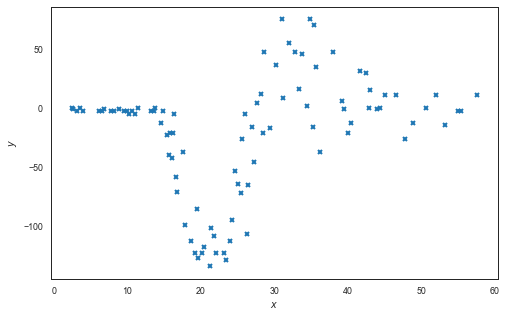

In [112]:
data = np.loadtxt('motor.dat')
x = torch.tensor(data[:, 0][:, None])
y = torch.tensor(data[:, 1][:, None])
n = len(x)
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(x, y, 'x', markeredgewidth=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

In [113]:
Ntrain = int(0.7*N)
Xtrain, Xval, Ytrain, Yval = train_test_split(X, Y, train_size=Ntrain)

# scale the data
xscaler = StandardScaler()
yscaler = StandardScaler()
Xtrain=xscaler.fit_transform(Xtrain)
Ytrain=yscaler.fit_transform(Ytrain)
Xval, Yval = xscaler.transform(Xval), yscaler.transform(Yval)

NameError: name 'train_test_split' is not defined

In [114]:
# instantiate the network 
layersizes = [1, 20, 20, 1]
activation = torch.tanh
net = NeuralNetwork(layersizes=layersizes, 
                    activation=activation)

# define a misfit function
mse = nn.MSELoss()

## L2 regularization
lmbda = 1e-3 # reg. constant 
def L2loss(lmbda, net):
    reg = torch.tensor(0.)
    for m in net.modules():
        if hasattr(m, 'weight'):
            reg += m.weight.norm()**2
    return lmbda*reg

### define an optimizer 
lr = 1e-2
update = torch.optim.Adam(params=net.parameters(), lr=lr)

# training loop params 
maxiter = 5000
batchsize = 32
Xtrain, Ytrain = torch.Tensor(Xtrain), torch.Tensor(Ytrain)
Xval, Yval = torch.Tensor(Xval), torch.Tensor(Yval)
best_stat_dict = net.state_dict()
best_val_mse_loss = np.inf

## training loop 
for i in range(maxiter):
    # sample a batch of data 
    batchidx = np.random.randint(0, len(Xtrain), batchsize)
    xbatch, ybatch = Xtrain[batchidx], Ytrain[batchidx]
    
    # zero out the gradient buffers
    update.zero_grad()
    
    #forward prop 
    ypred = net(xbatch)
    
    # compute the regularized loss 
    loss = mse(ypred, ybatch) + L2loss(lmbda, net)
    
    # back prop to get gradients 
    loss.backward()
    
    # take one optimization step
    update.step()
    
    # print progress 
    if (i+1)%100 == 0:
        val_mse_loss = mse(Yval, net(Xval))
        print(' [Iteration %4d] Validation MSE loss: %.3f'%(i+1, val_mse_loss))
        if val_mse_loss < best_val_mse_loss:
            best_state_dict = net.state_dict()
net.load_state_dict(best_stat_dict);

NameError: name 'NeuralNetwork' is not defined

In [ ]:
Xtest = torch.Tensor(xscaler.transform(np.linspace(0., 60., 1000)[:, None]))
Ypred = net(Xtest)

plt.figure( figsize=(10, 8) )
plt.plot(xscaler.inverse_transform(Xtest.data.numpy()), 
         yscaler.inverse_transform(Ypred.data.numpy()),
         linewidth=3,
         label='Test Predictions')
plt.plot(X, Y, 'ro', label='Data')
plt.legend(loc='best', fontsize=20)

## Non-exhaustive list of topics not covered here:

1. Regularizing a neural network with techniques such as dropout (`nn.Dropout`), batch normalization (`nn.BatchNorm1D`, `nn.BatchNorm2D`, `nn.BatchNorm3D`).

2. Weight Initialization (uniform, normal, [Xavier initialization](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf), [He initialization](https://arxiv.org/pdf/1502.01852.pdf) etc.) All common initialization techniques can be found under `nn.init` ([see here](https://pytorch.org/docs/stable/nn.init.html#nn-init-doc)).

3. Learning rate (or step size) schedule (Step schedule, exponential schedule, cosine annealing etc.) ([look for the section on how to adjust learning rate here](https://pytorch.org/docs/stable/optim.html)).

4. Hyperparameter optimization (grid search, cross-validation, Bayesian optimization etc.)

5. Model averaging. 

6. Stochastic weight averaging - https://arxiv.org/abs/1803.05407. This feature is available in `PyTorch`; [see here](https://pytorch.org/blog/stochastic-weight-averaging-in-pytorch/?utm_source=social-facebook&utm_medium=PyTorch&utm_campaign=organic&utm_content=post-url&utm_offering=artificial-intelligence&utm_product=AIStochasticWeight_050819&fbclid=IwAR28pSPYvd-9Qlx2nOvZF7c965TcnvNQENytm1HKQy1vKLHNifEZRzp5S8s).

## Bayesian Neural Network 

Starting with a prior $p(\theta)$ on the DNN weights and biases and a likelihood model $p(\mathcal{D} | \theta)$, we wish to approximate the posterior distribution over the DNN weights and biases $p(\theta | \mathcal{D})$. 

To efficiently implement and train a Bayesian Neural Network, we will use the `pyro` probabilistic programming library which is written on top of `PyTorch`. 

In [ ]:
import pyro
import pyro.distributions as dist 
from pyro import infer
from pyro import optim 
from pyro.contrib import autoguide
from pyro.nn import PyroSample, PyroModule

In [ ]:
class BayesianNeuralNetwork( PyroModule ):
    def __init__(self, layersizes=[1, 1], activation = torch.tanh,
                 final_layer_activation = None, 
                 prior_scale = 0.1, 
                 sigma = 0.1):
        """
        INPUTS:
            layersizes <list/tuple>: An iterable ordered object containing
                                 the sizes of the tensors from the
                                 input layer to the final output. 
                                 (See example below). 
            activation <callable>: A python callable through which
                                    torch backpropagation is possible.
            final_layer_activation <callable>: A python callable for 
                                    the final layer activation function.
                                    Default: None (for regression problems)
            prior_scale <float>: The prior standard deviation over the weights. 
            sigma <float>: The likelihood noise standard deviation
        """
        super(BayesianNeuralNetwork, self).__init__()
        self.prior_scale = prior_scale
        self.sigma       = sigma
        self.layersizes = layersizes
        self.input_dim = self.layersizes[0]
        self.hidden_sizes = self.layersizes[1:-1]
        self.output_dim = self.layersizes[-1]
        self.activation = activation
        self.final_layer_activation = final_layer_activation
        if self.final_layer_activation is None:
            self.final_layer_activation = nn.Identity()
        self.nlayers = len(self.hidden_sizes) + 1
        self.layernames = [] 
        
        # define FC layers
        # to treat the parameters of the network as latent variables
        # place priors over them using PyroSample 
        for i in range(self.nlayers):
            layername = 'fc_{}'.format(i+1)
            self.layernames.append(layername)
            layer = PyroModule[nn.Linear](self.layersizes[i], self.layersizes[i+1])
            weightprior = dist.Normal(0., prior_scale).expand(layer.weight.shape).to_event(2)
            biasprior = dist.Normal(0., prior_scale).expand(layer.bias.shape).to_event(1)
            layer.weight = PyroSample(weightprior)
            layer.bias = PyroSample(biasprior)
            setattr(self, layername, layer)
        
    def forward(self, x, y=None):
        """
        Specify the generative process here. 
        
        INPUTS:
            x -> Input features on which to condition the observations. 
            y -> Observed data. 
            
        RETURNS:
            loc -> Predictive mean.
        """
        ysigma = self.sigma 
        
        # get the mean 
        ymean = x
        for i, layername in enumerate(self.layernames):
            fclayer = getattr(self, layername)
            ymean = fclayer(ymean)
            if i == self.nlayers - 1:
                ymean = self.final_layer_activation( ymean )
            else:
                ymean = self.activation( ymean )
        ymean = ymean[:,0]
                
        # pyro.plate will take care of mini batch scaling 
        with pyro.plate('data', x.shape[0]):
            y = pyro.sample('y', dist.Normal(ymean, ysigma), obs=y)
        
        return ymean

In [ ]:
# instantiate the Bayesian Neural network 
prior_scale = 1.
sigma = 1e-1
bnn = BayesianNeuralNetwork(layersizes=[1, 200, 1], 
                            prior_scale=prior_scale,
                            sigma=1e-1)   # this will be the pyro `model` 

`pyro` has several choices for the variational posterior:

In [ ]:
[name for name in dir(infer.autoguide) if 'Auto' in name]

In [ ]:
# training validation splot and preprocessing 
Ntrain = int(0.7*N)
Xtrain, Xval, Ytrain, Yval = train_test_split(X, Y, train_size=Ntrain)

# scale the data
xscaler = StandardScaler()
yscaler = StandardScaler()
Xtrain=xscaler.fit_transform(Xtrain)
Ytrain=yscaler.fit_transform(Ytrain)
Xval, Yval = xscaler.transform(Xval), yscaler.transform(Yval)

In [ ]:
# instantiate the variational posterior 
q_bnn = infer.autoguide.AutoDiagonalNormal( bnn )

# always clear the parameter store before inference
pyro.clear_param_store()  

# define a loss function 
loss = infer.trace_elbo.Trace_ELBO(num_particles=5)

# define an optimizer 
optim_dict = {'lr':1e-2}  # dictionary of optimizer settings
optimizer = pyro.optim.Adam(optim_dict)

# instantiate the inference engine 
svi = infer.SVI(model=bnn, 
                guide=q_bnn, 
                optim=optimizer, 
                loss=loss)

### TRAINING LOOP ###
niters = 5000
losses = []
Xtrain, Ytrain = torch.Tensor(Xtrain), torch.Tensor(Ytrain)
Xval, Yval = torch.Tensor(Xval), torch.Tensor(Yval)
data = torch.Tensor(Y)
for i in tqdm_notebook(range(niters)):
    loss = svi.step(Xtrain, Ytrain[:,0])
    losses.append(loss)

Let's check the ELBO.

In [ ]:
plt.figure(figsize=(10, 8))
losses = np.array(losses)
plt.plot(np.arange(1, niters+1), -losses)
plt.ylabel('ELBO', fontsize=15)
plt.xlabel('Iteration', fontsize=15)
plt.tight_layout()

Now let's get the posterior predictive samples. 

In [ ]:
Xtest = torch.Tensor(xscaler.transform(np.linspace(0., 60., 500)[:, None]))
predictor = infer.Predictive(model=bnn, 
                             guide=q_bnn, 
                             num_samples=1000, 
                             return_sites=("y", "_RETURN"))
ppsamples = predictor(Xtest)

In [ ]:
ppmean = ppsamples["_RETURN"].data.numpy().mean(0)
ppmean = yscaler.inverse_transform(ppmean)
pplow, pphigh = np.percentile(ppsamples["_RETURN"].data.numpy(), axis=0, q=[2.5, 97.5])
pplow = yscaler.inverse_transform(pplow)
pphigh = yscaler.inverse_transform(pphigh)

In [ ]:
plt.figure( figsize=(10, 8) )
Xtest=xscaler.inverse_transform(Xtest.data.numpy())
plt.plot(Xtest, 
         ppmean,
         linewidth=3,
         label='Test Predictions')
plt.fill_between(Xtest[:,0], pplow, pphigh, alpha=0.25, label='95% interval')
plt.plot(X, Y, 'ro', label='Data')

plt.legend(loc='best', fontsize=20)